**автоматический переводчик на основе рекуррентных нейросетей seq2seq**

Евгений Борисов borisov.e@solarl.ru

In [1]:
# https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

## Библиотеки

In [2]:
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [3]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )    

## Данные

In [4]:
# http://www.manythings.org/anki/
    
# список фраз на английском с переводом на русский
with open('../data/text/rus-eng/rus.txt', 'rt', encoding='utf-8') as f:
    lines = f.read().lower().split('\n')

ppr(lines)    

записей: 336 667


---

In [5]:
# фразы упорядоченны по длине, выберем среднюю длину
lines = [ lines[i] for i in range(100000,110000) ]
ppr(lines)  

записей: 10 000


In [6]:
# разбираем строки на русские и английские с сохранением порядка

# определим специальные символы - начало и конец фразы
GO='\t' # символ <старт>
EOS='\n' # символ <стоп>

input_texts  = [ s.split('\t')[0] for s in lines if s ] 
target_texts = [ GO + ' ' + s.split('\t')[1]+ ' ' + EOS for s in lines if s ]

In [7]:
# входной и выходной алфавиты
input_characters  = sorted(set(' '.join(input_texts)))
target_characters = sorted(set(' '.join(target_texts)))

In [8]:
# размер входного алфавита
num_encoder_tokens = len(input_characters) 
# максимальная длина входной фразы в символах 
max_encoder_seq_length = max([len(txt) for txt in input_texts])

# размер выходного алфавита
num_decoder_tokens = len(target_characters)
# максимальная длина выходной фразы в символах 
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [9]:
# нумеруем символы в алфавите
input_token_index = { char:i for i, char in enumerate(input_characters) }
target_token_index = { char:i  for i, char in enumerate(target_characters) }

## кодируем текст

In [10]:
# строим статистическую модель порождения текста 




# Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares,
#     Holger Schwenk, Yoshua Bengio
# Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation
# 3 Sep 2014
# https://arxiv.org/abs/1406.1078




# statistical machine translation system (SMT)

# the goal of the system (decoder,specifically) is to 
# find a translation f given a source sentence e, which maximizes

# p(f|e) ∝ p(e|f)p(f)



In [11]:
# для каждого примера
#   строим таблицу индикаторов  {0,1}
#     [ номер слова в последовательности, номер символа в алфавите ] 

In [12]:
# данные энкодера 

# входная последовательность генерирует выход по схеме many2one 
#   выход энкодера выкидываем
#    используем только его конечное состояние
#      первым входом декодера есть служебное слово <пуск>
encoder_input_data = np.zeros( (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')

for s, input_text in enumerate(input_texts):
    for w, c in enumerate(input_text):
        encoder_input_data[s, w, input_token_index[c]] = 1.

In [13]:
# данные декодера (для целевой последовательности), 

# память декодера инициализируеться конечным состянием памяти энкодера 
#   и на вход подаём служебное слово <пуск>    
#    далее рекурсивно - очередной выход декодера подаёться на вход и генерирует следующий выход

# вход декодера
decoder_input_data = np.zeros( (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
# выход декодера (вход смещённый на один шаг)
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, target_text in enumerate(target_texts):
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

## модель

In [14]:
latent_dim = 512  # размер сети

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 47)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 67)     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 512), (None, 1146880     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 512),  1187840     input_2[0][0]                    
                                                                 lstm[0][1]                       
          

In [16]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

## обучаем модель

In [17]:
%%time 

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=100,
          epochs=20,
          validation_split=0.2
        )

Train on 8000 samples, validate on 2000 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
8000/8000 [==============================] - 104s 13ms/sample - loss: 1.1859 - val_loss: 1.1115
Epoch 2/100
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.9547 - val_loss: 0.9483
Epoch 3/100
8000/8000 [==============================] - 100s 13ms/sample - loss: 0.8327 - val_loss: 0.8731
Epoch 4/100
8000/8000 [==============================] - 101s 13ms/sample - loss: 0.7779 - val_loss: 0.8298
Epoch 5/100
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.7187 - val_loss: 0.7985
Epoch 6/100
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.6745 - val_loss: 0.7664
Epoch 7/100
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.6331 - val_loss: 0.7342
Epoch 8/100
8000/8000 [==============================] - 98s 12ms/sample -

8000/8000 [==============================] - 98s 12ms/sample - loss: 0.0576 - val_loss: 1.2834
Epoch 72/100
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.0562 - val_loss: 1.2857
Epoch 73/100
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.0544 - val_loss: 1.3337
Epoch 74/100
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.0526 - val_loss: 1.3054
Epoch 75/100
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.0511 - val_loss: 1.3169
Epoch 76/100
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.0497 - val_loss: 1.3128
Epoch 77/100
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.0483 - val_loss: 1.3166
Epoch 78/100
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.0467 - val_loss: 1.3258
Epoch 79/100
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.0454 - val_loss: 1.3383
Epoch 80/100
8000/8000 [=================

In [18]:
# Save model
# model.save('s2s.h5')

## Тестируем

In [19]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model( [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [20]:
reverse_input_char_index = { i:char for char,i in input_token_index.items() }
reverse_target_char_index = { i:char for char,i in target_token_index.items() }

In [21]:
def decode_sequence(input_seq):
    # генерируем состояние энкодера
    states_value = encoder_model.predict(input_seq)

    # вход декодера - последовательность из одного слова GO
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index[GO]] = 1.

    # выходную последовательность
    stop_condition = False
    decoded_sentence = ''
    
    for i in range(max_decoder_seq_length): 
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # декодируем символ
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # если очередной символ это EOS
        if(sampled_char==EOS): break # то завершаем работу

        # обновляем входную последовательность
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # обновляем состояние сети
        states_value = [h, c]

    return decoded_sentence

In [36]:
ii = np.random.permutation(len(encoder_input_data))[:100]
for seq_index in ii:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print( input_texts[seq_index],' -> ', decoded_sentence)

what a beautiful woman!  ->   какая красивая женщина! 

tom will have to leave.  ->   тому придётся уехать. 

it doesn't matter, tom.  ->   это неважно, том. 

we'll never forget tom.  ->   мы никогда не забудем тома. 

do you have news for me?  ->   скажите тому, где вы. 

why don't you eat meat?  ->   почему ты не ешь мясо? 

the clothes are drying.  ->   одежда сохнет. 

no one will be at home.  ->   никого не будет дома. 

what is tom doing here?  ->   что том здесь делает? 

tom doesn't know where.  ->   том не знает где. 

crack is very addictive.  ->   спасибо за ссылку. 

don't you recognize tom?  ->   скажите это ему, а не мне! 

tom will do that later.  ->   том сделает это позже. 

please take care of it.  ->   пожалуйста, позаботьтесь об этом. 

tell tom what happened.  ->   расскажите тому, что случилось. 

tom doesn't like chess.  ->   том не любит шахматы. 

that's hard to believe.  ->   верится с трудом. 

does she play the piano?  ->   расскажите мне об этом парне. 

y

---

In [23]:
import matplotlib.pyplot as plt

In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

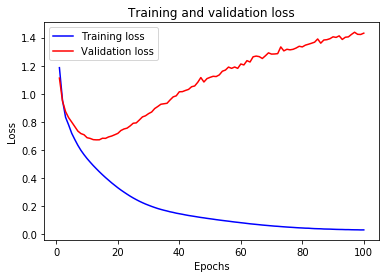

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

---

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

In [33]:
print('tensorflow:', tf.__version__)
print('keras:', keras.__version__)

if tf.test.is_built_with_cuda():
    print('GPU devices:\n  ',
        [ [x.name, x.physical_device_desc] 
          for x in device_lib.list_local_devices() 
          if x.device_type == 'GPU' ]
    )
    print('default GPU device:', tf.test.gpu_device_name() )

else:
    print('no GPU device found')
    

tensorflow: 1.13.1
keras: 2.2.4-tf
GPU devices:
   [['/device:GPU:0', 'device: 0, name: GeForce GT 730, pci bus id: 0000:01:00.0, compute capability: 3.5']]
default GPU device: /device:GPU:0


---

In [26]:
# '''
# #Sequence to sequence example in Keras (character-level).

# This script demonstrates how to implement a basic character-level
# sequence-to-sequence model. We apply it to translating
# short English sentences into short French sentences,
# character-by-character. Note that it is fairly unusual to
# do character-level machine translation, as word-level
# models are more common in this domain.

# **Summary of the algorithm**

# - We start with input sequences from a domain (e.g. English sentences)
#     and corresponding target sequences from another domain
#     (e.g. French sentences).
# - An encoder LSTM turns input sequences to 2 state vectors
#     (we keep the last LSTM state and discard the outputs).
# - A decoder LSTM is trained to turn the target sequences into
#     the same sequence but offset by one timestep in the future,
#     a training process called "teacher forcing" in this context.
#     It uses as initial state the state vectors from the encoder.
#     Effectively, the decoder learns to generate `targets[t+1...]`
#     given `targets[...t]`, conditioned on the input sequence.
# - In inference mode, when we want to decode unknown input sequences, we:
#     - Encode the input sequence into state vectors
#     - Start with a target sequence of size 1
#         (just the start-of-sequence character)
#     - Feed the state vectors and 1-char target sequence
#         to the decoder to produce predictions for the next character
#     - Sample the next character using these predictions
#         (we simply use argmax).
#     - Append the sampled character to the target sequence
#     - Repeat until we generate the end-of-sequence character or we
#         hit the character limit.

# **Data download**

# [English to French sentence pairs.
# ](http://www.manythings.org/anki/fra-eng.zip)

# [Lots of neat sentence pairs datasets.
# ](http://www.manythings.org/anki/)

# **References**

# - [Sequence to Sequence Learning with Neural Networks
#    ](https://arxiv.org/abs/1409.3215)
# - [Learning Phrase Representations using
#     RNN Encoder-Decoder for Statistical Machine Translation
#     ](https://arxiv.org/abs/1406.1078)
# '''

In [27]:
# output_characters
# input_characters
# input_texts
# output_texts

In [28]:
# num_samples = 10000  # Number of samples to train on.

# # Vectorize the data.
# input_texts = []
# target_texts = []
# input_characters = set()
# target_characters = set()

# with open('../data/text/rus-eng/rus.txt', 'rt', encoding='utf-8') as f:
#     lines = f.read().split('\n')
    
# for line in lines[: min(num_samples, len(lines) - 1)]:
#     input_text, target_text = line.split('\t')
#     # We use "tab" as the "start sequence" character
#     # for the targets, and "\n" as "end sequence" character.
#     target_text = '\t' + target_text + '\n'
#     input_texts.append(input_text)
#     target_texts.append(target_text)
#     for char in input_text:
#         if char not in input_characters:
#             input_characters.add(char)
#     for char in target_text:
#         if char not in target_characters:
#             target_characters.add(char)

# input_characters = sorted(list(input_characters))
# target_characters = sorted(list(target_characters))
# num_encoder_tokens = len(input_characters)
# num_decoder_tokens = len(target_characters)
# max_encoder_seq_length = max([len(txt) for txt in input_texts])
# max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [29]:
# for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
#     for t, char in enumerate(input_text):
#         encoder_input_data[i, t, input_token_index[char]] = 1.
        
#     for t, char in enumerate(target_text):
#         # decoder_target_data is ahead of decoder_input_data by one timestep
#         decoder_input_data[i, t, target_token_index[char]] = 1.
#         if t > 0:
#             # decoder_target_data will be ahead by one timestep
#             # and will not include the start character.
#             decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [30]:
# # Next: inference mode (sampling).
# # Here's the drill:
# # 1) encode input and retrieve initial decoder state
# # 2) run one step of decoder with this initial state
# # and a "start of sequence" token as target.
# # Output will be the next target token
# # 3) Repeat with the current target token and current states

# # Define sampling models
# encoder_model = Model(encoder_inputs, encoder_states)

# decoder_state_input_h = Input(shape=(latent_dim,))
# decoder_state_input_c = Input(shape=(latent_dim,))
# decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
# decoder_states = [state_h, state_c]
# decoder_outputs = decoder_dense(decoder_outputs)
# decoder_model = Model( [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [31]:
# for seq_index in range(100):
#     # Take one sequence (part of the training set)
#     # for trying out decoding.
#     input_seq = encoder_input_data[seq_index: seq_index + 1]
#     decoded_sentence = decode_sequence(input_seq)
#     print('-')
#     print('Input sentence:', input_texts[seq_index])
#     print('Decoded sentence:', decoded_sentence)